In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
import datetime
import openpyxl
import warnings

%matplotlib inline

from sklearn.model_selection import cross_val_score
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

sns.set()

warnings.filterwarnings('ignore')

# Converting quarterly GDP data to monthly GDP data

In [2]:
gdp_df=pd.read_excel('GDP_Per_Capita.xls')

In [3]:
gdp_df.head()

,Month,GDP
0,1968-04-01,25652
1,1968-07-01,25781
2,1968-10-01,25813
3,1969-01-01,26162
4,1969-04-01,26181


In [4]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   222 non-null    datetime64[ns]
 1   GDP     222 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.6 KB


In [5]:
gdp_df=gdp_df.set_index('Month').resample('MS').interpolate()

In [6]:
gdp_df.head(10)  # Jan’87 to Sep’23 

,GDP
Month,
1968-04-01,25652.000000
1968-05-01,25695.000000
1968-06-01,25738.000000
1968-07-01,25781.000000
1968-08-01,25791.666667
1968-09-01,25802.333333
1968-10-01,25813.000000
1968-11-01,25929.333333
1968-12-01,26045.666667


In [7]:
gdp_df=gdp_df['1987-01':'2023-11']

In [8]:
gdp_df

,GDP
Month,
1987-01-01,37132.000000
1987-02-01,37239.333333
1987-03-01,37346.666667
1987-04-01,37454.000000
1987-05-01,37531.000000
...,...
2023-03-01,66253.333333
2023-04-01,66341.000000
2023-05-01,66588.333333


In [9]:
df=pd.read_excel('homedata.xls')

In [10]:
df.head()

,DATE,POP,MORTGAGE_RATES,FED_RATES,EMP_RATES,UNEMP_RATES,CPI_MEDIAN(% CHG),DISPOSABLE_INCOME,FOR_SALE_AT_EOM,SOLD_THAT_MONTH,HOUSE_PRICE_INDEX
0,1987-01-01,241857.0,9.2040,6.43,70.165412,6.6,5.358298,6494.2,355.0,53.0,63.735
1,1987-02-01,242005.0,9.0825,6.10,70.291684,6.6,3.337758,6525.0,349.0,59.0,64.135
2,1987-03-01,242166.0,9.0350,6.13,70.325074,6.6,3.798986,6530.5,352.0,73.0,64.470
3,1987-04-01,242338.0,9.8325,6.37,70.501030,6.3,4.732866,6282.3,355.0,72.0,64.973
4,1987-05-01,242516.0,10.5960,6.85,70.812099,6.3,4.506360,6537.0,352.0,62.0,65.547


In [11]:
df = df.rename(columns={'DATE': 'Month'})

In [12]:
df=pd.merge(df,gdp_df,on='Month', how='inner')

In [13]:
df.sample(6)

,Month,POP,MORTGAGE_RATES,FED_RATES,EMP_RATES,UNEMP_RATES,CPI_MEDIAN(% CHG),DISPOSABLE_INCOME,FOR_SALE_AT_EOM,SOLD_THAT_MONTH,HOUSE_PRICE_INDEX,GDP
280,2010-05-01,309485.0,4.8875,0.20,66.755671,9.6,0.275748,12540.3,215.0,26.0,147.040,54200.333333
151,1999-08-01,279752.0,7.9425,5.07,73.910263,4.2,2.361582,9559.1,295.0,78.0,97.897,48848.333333
380,2018-09-01,329216.0,4.6275,1.95,70.766997,3.7,2.333723,15237.5,326.0,46.0,205.378,61620.000000
407,2020-12-01,332047.0,2.6840,0.09,67.921318,6.7,1.624482,16406.1,302.0,63.0,234.390,62956.000000
241,2007-02-01,300608.0,6.2850,5.26,71.975398,4.5,4.447026,11996.0,540.0,68.0,182.471,55331.333333
147,1999-04-01,278584.0,6.9160,4.74,73.815244,4.3,2.675990,9453.0,289.0,86.0,94.436,48148.000000


In [14]:
df=df.rename(columns={'GDP':'GDP_PER_CAPITA'})

In [15]:
for column in ['GDP_PER_CAPITA','EMP_RATES','CPI_MEDIAN(% CHG)','MORTGAGE_RATES','EMP_RATES']:
    df[column] = df[column].round(2)

In [16]:
df.head()

,Month,POP,MORTGAGE_RATES,FED_RATES,EMP_RATES,UNEMP_RATES,CPI_MEDIAN(% CHG),DISPOSABLE_INCOME,FOR_SALE_AT_EOM,SOLD_THAT_MONTH,HOUSE_PRICE_INDEX,GDP_PER_CAPITA
0,1987-01-01,241857.0,9.20,6.43,70.17,6.6,5.36,6494.2,355.0,53.0,63.735,37132.00
1,1987-02-01,242005.0,9.08,6.10,70.29,6.6,3.34,6525.0,349.0,59.0,64.135,37239.33
2,1987-03-01,242166.0,9.04,6.13,70.33,6.6,3.80,6530.5,352.0,73.0,64.470,37346.67
3,1987-04-01,242338.0,9.83,6.37,70.50,6.3,4.73,6282.3,355.0,72.0,64.973,37454.00
4,1987-05-01,242516.0,10.60,6.85,70.81,6.3,4.51,6537.0,352.0,62.0,65.547,37531.00


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439 entries, 0 to 438
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Month              439 non-null    datetime64[ns]
 1   POP                439 non-null    float64       
 2   MORTGAGE_RATES     439 non-null    float64       
 3   FED_RATES          439 non-null    float64       
 4   EMP_RATES          439 non-null    float64       
 5   UNEMP_RATES        439 non-null    float64       
 6   CPI_MEDIAN(% CHG)  439 non-null    float64       
 7   DISPOSABLE_INCOME  439 non-null    float64       
 8   FOR_SALE_AT_EOM    439 non-null    float64       
 9   SOLD_THAT_MONTH    439 non-null    float64       
 10  HOUSE_PRICE_INDEX  439 non-null    float64       
 11  GDP_PER_CAPITA     439 non-null    float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 44.6 KB


In [18]:
df.columns

Index(['Month', 'POP', 'MORTGAGE_RATES', 'FED_RATES', 'EMP_RATES',
       'UNEMP_RATES', 'CPI_MEDIAN(% CHG)', 'DISPOSABLE_INCOME',
       'FOR_SALE_AT_EOM', 'SOLD_THAT_MONTH', 'HOUSE_PRICE_INDEX',
       'GDP_PER_CAPITA'],
      dtype='object')

In [19]:
columns_to_plot=['MORTGAGE_RATES','POP', 'FED_RATES', 'EMP_RATES', 'UNEMP_RATES',
       'CPI_MEDIAN(% CHG)', 'DISPOSABLE_INCOME', 'FOR_SALE_AT_EOM',
       'SOLD_THAT_MONTH','GDP_PER_CAPITA','HOUSE_PRICE_INDEX']

# Checking how variables vary over time

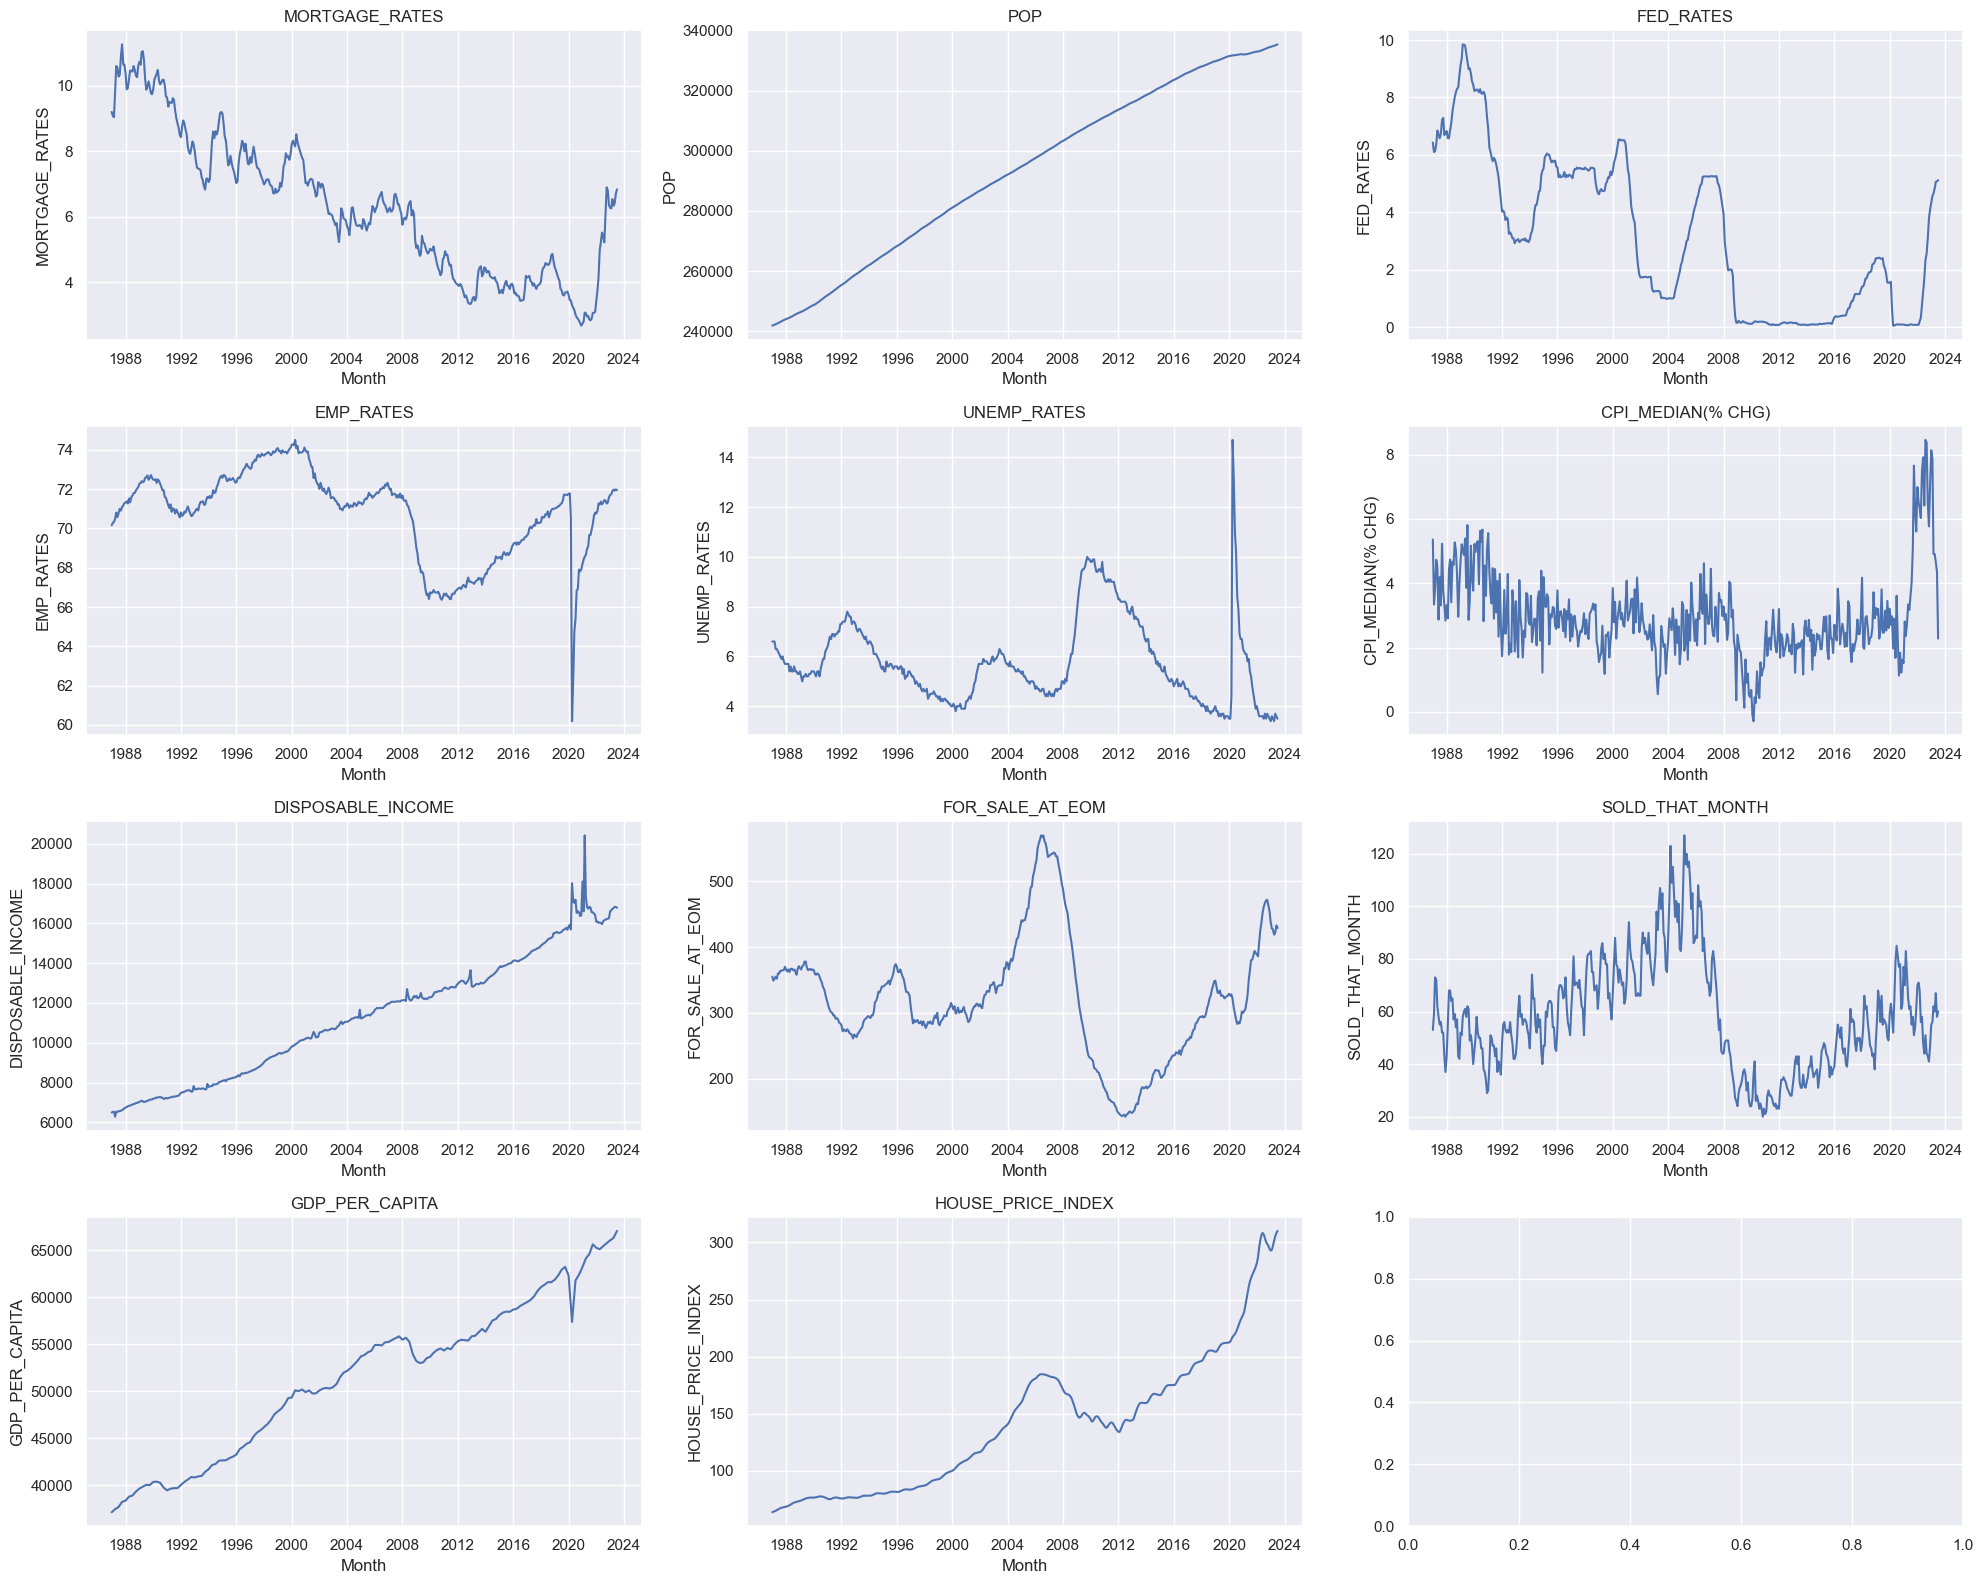

In [20]:
# Creating subplots
fig, axs = plt.subplots(4,3, figsize=(20, 16))

# Flatten the 2D array of subplots for ease of indexing
axs = axs.flatten()

# Loop through columns and plot against 'Year'
for i,column in enumerate(columns_to_plot):
    ax = axs[i]
    ax.plot(df['Month'],df[column])
    ax.set_title(column)
    ax.set_xlabel('Month')
    ax.set_ylabel(column)
    
plt.tight_layout()    
plt.show() 

# Checking Distribution of Variables

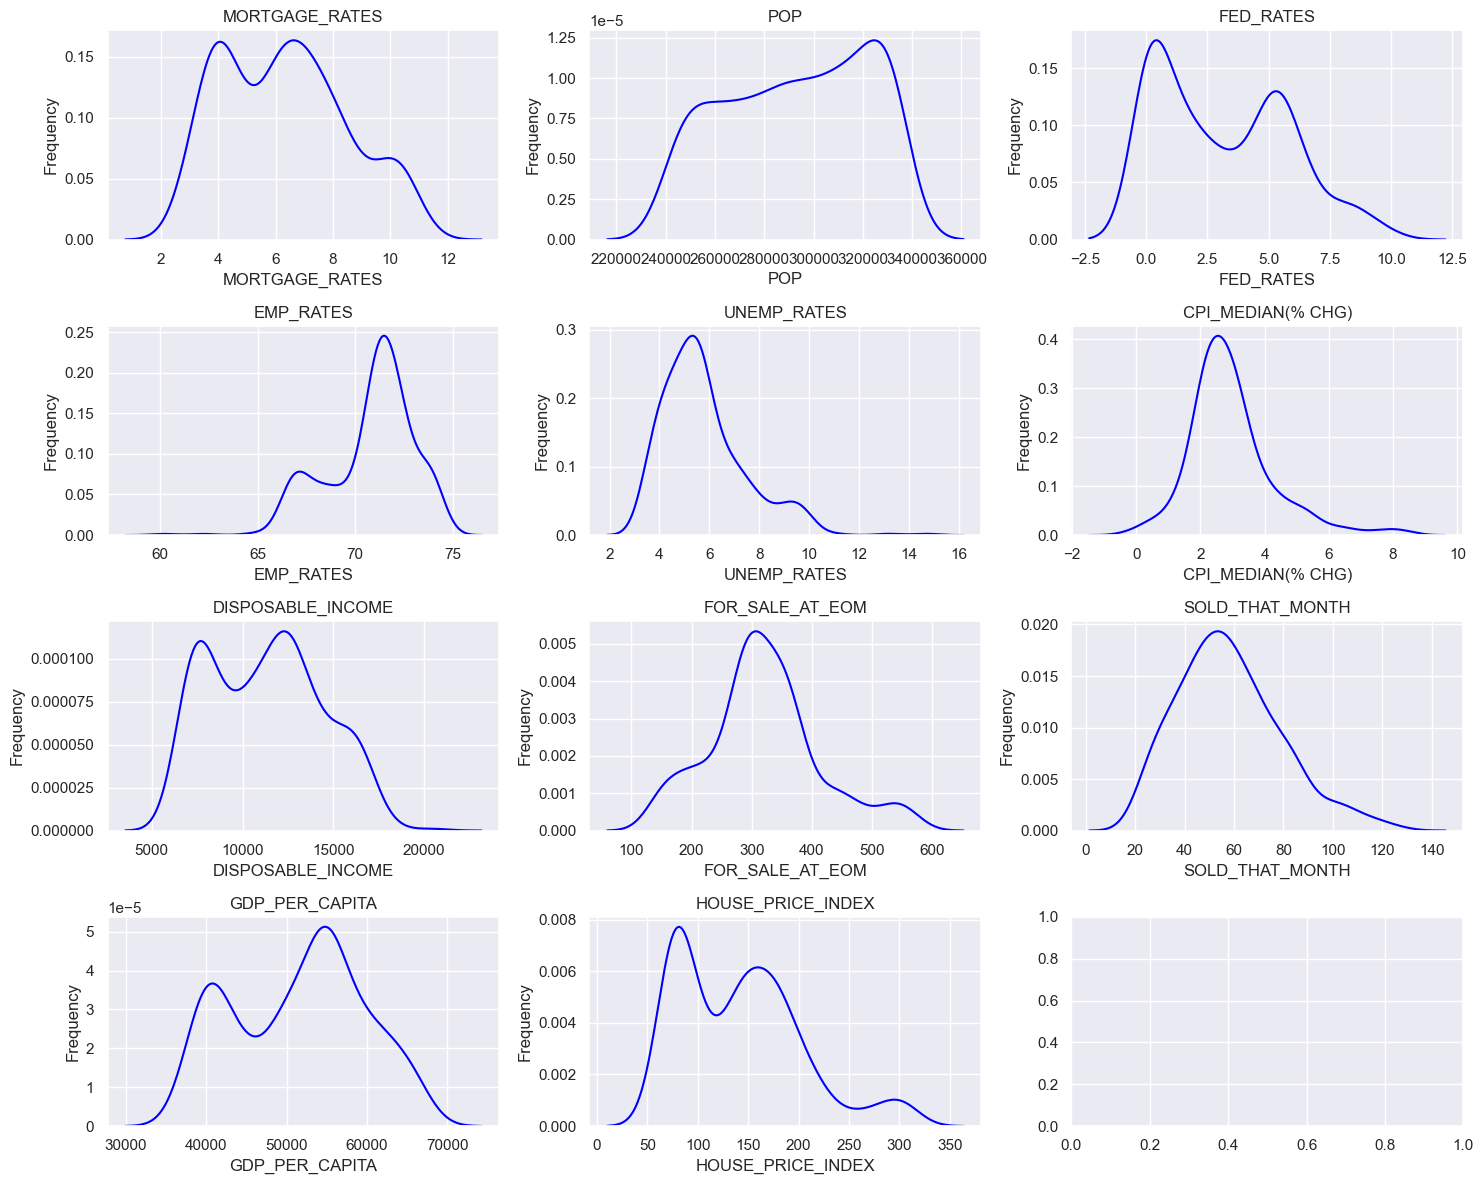

In [21]:
# Creating subplots
fig, axs = plt.subplots(4,3, figsize=(15, 12))

# Flatten the 2D array of subplots for ease of indexing
axs = axs.flatten()

# Loop through columns and plot histograms
for i, column in enumerate(columns_to_plot):
    ax = axs[i]
    sns.kdeplot(df[column], color='blue', ax=ax)
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Relationship of Input variables with Output Variable

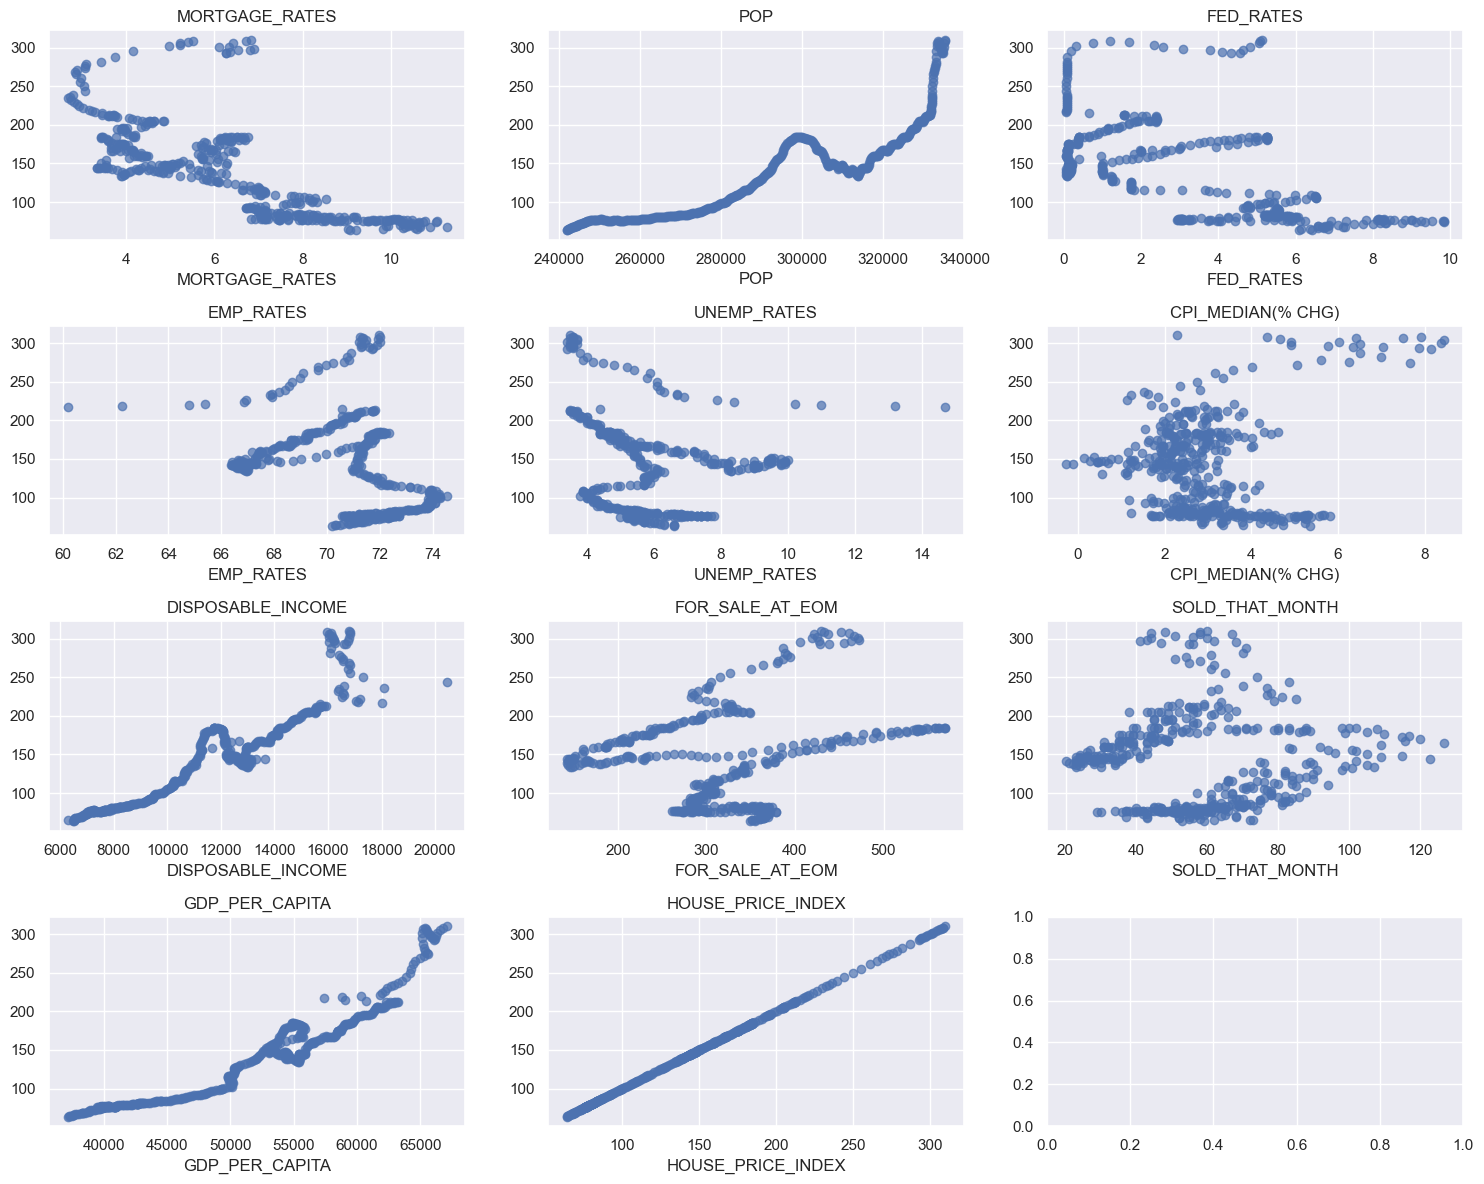

In [22]:
# Create subplots
fig, axs = plt.subplots(4,3, figsize=(15, 12))

# Flatten the 2D array of subplots for ease of indexing
axs = axs.flatten()

# Loop through columns and plot scatter plots
for i, column in enumerate(columns_to_plot):
    ax = axs[i]
    ax.scatter(df[column], df['HOUSE_PRICE_INDEX'], alpha=0.7)
    ax.set_title(f'{column}')
    ax.set_xlabel(column)
    

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Checking for Normality in data

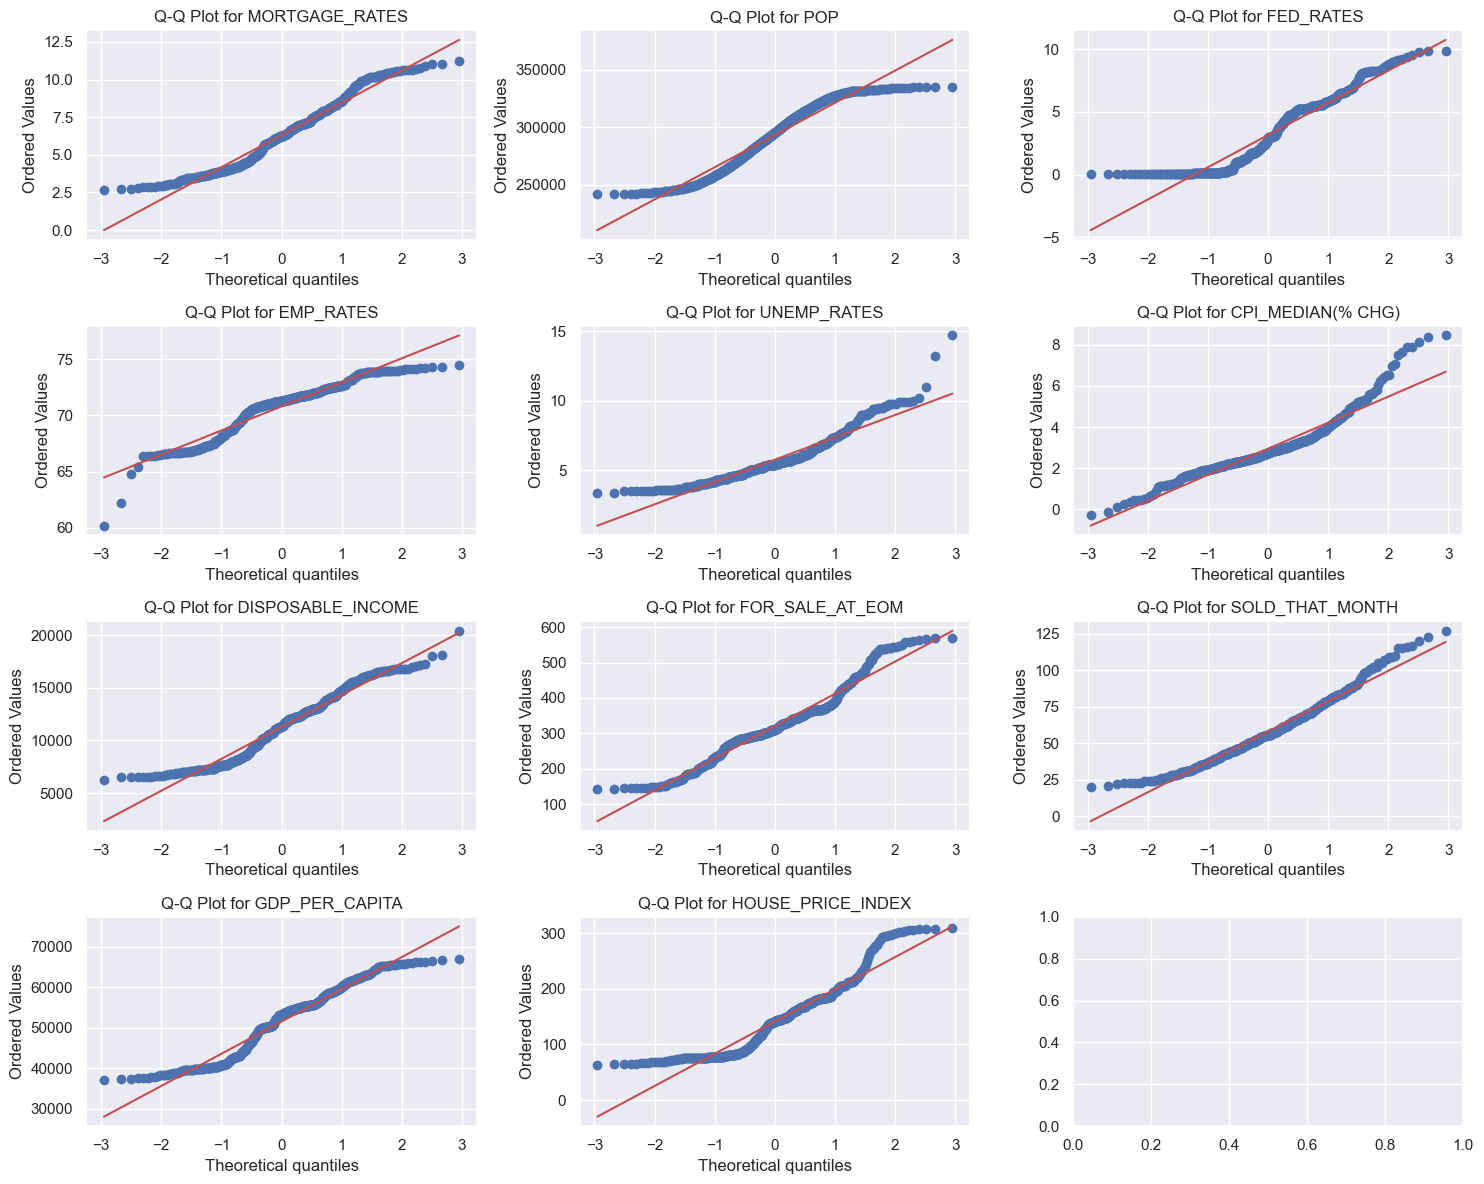

In [23]:
# Creating subplots
fig,axs = plt.subplots(4,3,figsize=(15, 12))

# Flatten the 2D array of subplots for ease of indexing
axs = axs.flatten()

# Loop through columns and plot Q-Q plots
for i, column in enumerate(columns_to_plot):
    ax = axs[i]
    stats.probplot(df[column], dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot for {column}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Outlier Detection and Removal

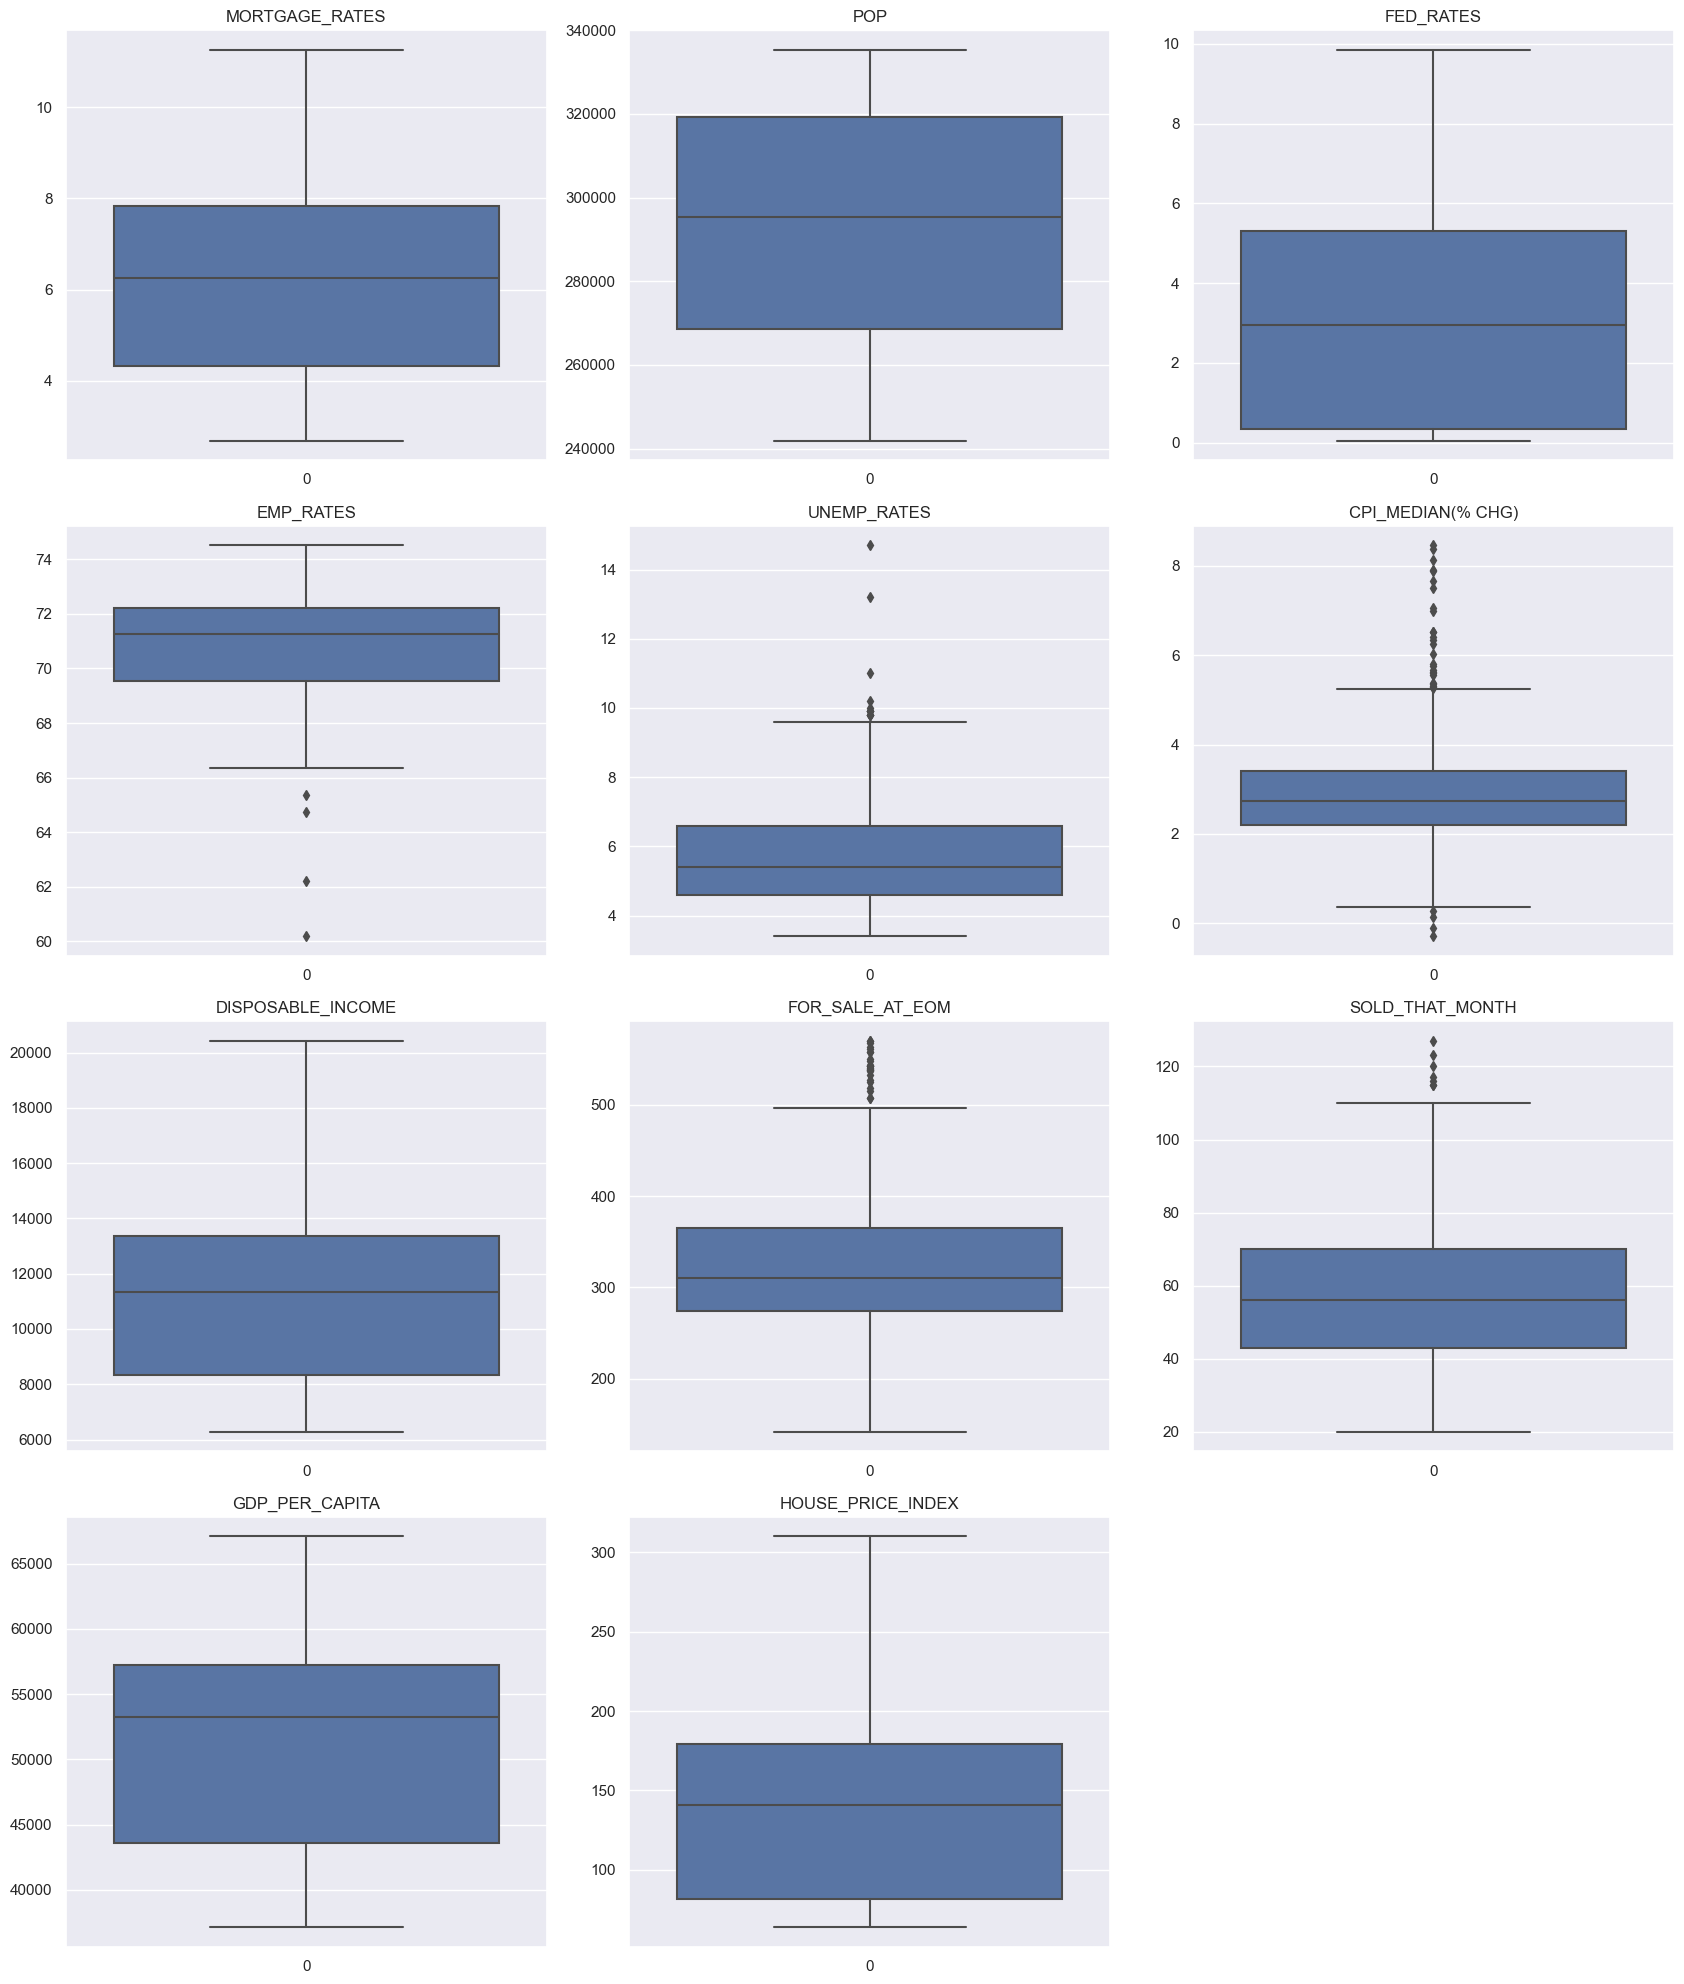

In [24]:
plt.figure(figsize=(17,20))
for i, col in enumerate(columns_to_plot):
    plt.subplot(4, 3, i+1)
    sns.boxplot(df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [25]:
def replace_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    
    df[col] = df[col].apply(lambda x: df[col].mean() if (x > upper_limit) or (x < lower_limit) else x)
    
    return df[col]

In [26]:
outlier_columns=['EMP_RATES','UNEMP_RATES','CPI_MEDIAN(% CHG)','FOR_SALE_AT_EOM','SOLD_THAT_MONTH']

In [27]:
for cols in outlier_columns:
    replace_outliers(df, cols)

# Detecting and Removing Multicollinearity if it exists

<Axes: >

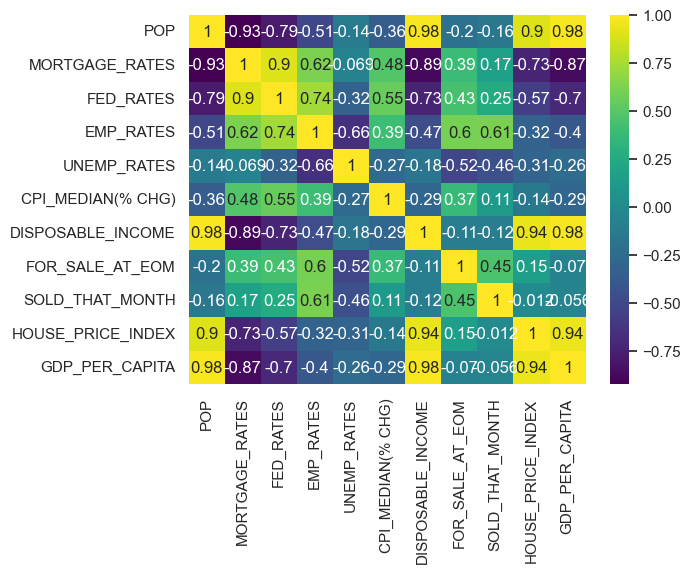

In [28]:
sns.heatmap(df.corr(), annot=True, cmap='viridis')

In [29]:
df=df.drop(columns=['MORTGAGE_RATES','EMP_RATES','POP','DISPOSABLE_INCOME','GDP_PER_CAPITA'])

<Axes: >

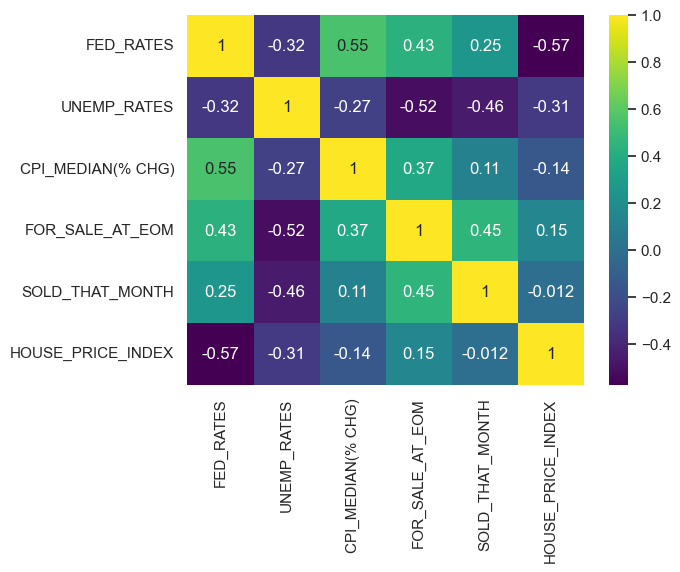

In [30]:
sns.heatmap(df.corr(), annot=True, cmap='viridis')

In [31]:
df=df.set_index('Month')

# Since we have to take last 20 years for model building, we modify dataframe as follows

In [32]:
df2 = df.loc['2003-10':'2023-09']

# Splitting data into Input Output variables

In [33]:
X=df2.drop(columns=['HOUSE_PRICE_INDEX'], axis=1)
y=df2['HOUSE_PRICE_INDEX']

# Dividing data into Train and Test sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 42)

# Standardization

In [35]:
scaler = StandardScaler()

In [36]:
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

# Model building

In [37]:
model = LinearRegression()

In [38]:
model.fit(x_train_scaled,y_train)

LinearRegression()

In [39]:
y_train_pred = model.predict(x_train_scaled)
y_test_pred  = model.predict(x_test_scaled)

In [40]:
r2_train = r2_score(y_train, y_train_pred)

# Calculate R2 score for testing set
r2_test = r2_score(y_test, y_test_pred)

print("R2 Score for Training Set:", r2_train)
print("R2 Score for Testing Set:", r2_test)

R2 Score for Training Set: 0.5167197379646368
R2 Score for Testing Set: 0.38971107267394034


In [41]:
coefs = model.coef_
cols = df2.columns
for i in range(len(coefs)):
    print(f"The coefficient for {cols[i]} is {coefs[i]}")

The coefficient for FED_RATES is -9.23457512432892
The coefficient for UNEMP_RATES is -21.833750314021803
The coefficient for CPI_MEDIAN(% CHG) is 9.127132482637622
The coefficient for FOR_SALE_AT_EOM is 17.19232686686297
The coefficient for SOLD_THAT_MONTH is -4.73999287175249


In [42]:
mse = mean_squared_error(y_train, y_train_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train, y_train_pred)

# Print the values
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 994.0288625998043
Root Mean Squared Error (RMSE): 31.528223270584157
Mean Absolute Error (MAE): 22.843526847552955


# Using OLS Method

In [43]:
x_train_with_const = sm.add_constant(x_train_scaled)


ols_model = sm.OLS(y_train, x_train_with_const).fit()

# Print the summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:      HOUSE_PRICE_INDEX   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     39.35
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           2.26e-27
Time:                        09:48:22   Log-Likelihood:                -925.27
No. Observations:                 190   AIC:                             1863.
Df Residuals:                     184   BIC:                             1882.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        186.1877      2.324     80.105      0.0

# Model building and evaluation using original dataset

In [44]:
X=df.drop(columns=['HOUSE_PRICE_INDEX'], axis=1)
y=df['HOUSE_PRICE_INDEX']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 42)

In [46]:
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [47]:
model = LinearRegression()

In [48]:
model.fit(x_train_scaled,y_train)

LinearRegression()

In [49]:
y_train_pred = model.predict(x_train_scaled)
y_test_pred  = model.predict(x_test_scaled)

In [50]:
r2_train = r2_score(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)

print("R2 Score for Training Set:", r2_train)
print("R2 Score for Testing Set:", r2_test)

R2 Score for Training Set: 0.6804055966502619
R2 Score for Testing Set: 0.6853935642016807


In [51]:
coefs = model.coef_
cols = df2.columns
for i in range(len(coefs)):
    print(f"The coefficient for {cols[i]} is {coefs[i]}")

The coefficient for FED_RATES is -53.49097379934849
The coefficient for UNEMP_RATES is -27.124353897100274
The coefficient for CPI_MEDIAN(% CHG) is 8.569351232916379
The coefficient for FOR_SALE_AT_EOM is 17.141648428472973
The coefficient for SOLD_THAT_MONTH is -7.942394339774911


In [52]:
mse = mean_squared_error(y_train, y_train_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train, y_train_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 1108.8350050978222
Root Mean Squared Error (RMSE): 33.29917424047963
Mean Absolute Error (MAE): 25.793295365045932


In [53]:
x_train_with_const = sm.add_constant(x_train_scaled)


ols_model = sm.OLS(y_train, x_train_with_const).fit()

# Print the summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:      HOUSE_PRICE_INDEX   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     146.9
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           3.39e-83
Time:                        09:48:22   Log-Likelihood:                -1728.5
No. Observations:                 351   AIC:                             3469.
Df Residuals:                     345   BIC:                             3492.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        143.2045      1.793     79.879      0.0